In [7]:
import os

import torch as t
import numpy as np
import einops
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import pickle
import torch.nn.functional as F
from tqdm import tqdm

from circuits.dictionary_learning.buffer import NNsightActivationBuffer
from circuits.dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
import circuits.othello_utils as othello_utils
from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

import circuits.analysis as analysis
import circuits.utils as utils
import circuits.othello_utils as othello_utils
import circuits.chess_utils as chess_utils

repo_dir = "/home/adam/chess-gpt-circuits/"
# repo_dir = '/share/u/can/chess-gpt-circuits'
device = 'cuda:0'

othello = True

In [8]:
if othello:
    # download data from huggingface if needed
    if not os.path.exists(f'{repo_dir}/autoencoders/othello_5-21'):
        hf_hub_download(repo_id='adamkarvonen/othello_saes', filename='othello_5-21.zip', local_dir=f'{repo_dir}/autoencoders')
        # unzip the data
        os.system(f'unzip {repo_dir}/autoencoders/othello_5-21.zip -d autoencoders')

In [9]:
# load SAE
ae_type = 'p_anneal'
trainer_id = 4

if othello:
    ae_path = f'{repo_dir}/autoencoders/othello_5-21/othello-{ae_type}/trainer{trainer_id}'
else:
    ae_path = f'{repo_dir}/autoencoders/chess-trained_model-layer_5-2024-05-23/chess-trained_model-layer_5-{ae_type}/trainer{trainer_id}'


if ae_type == 'standard' or ae_type == 'p_anneal':
    ae = AutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'gated' or ae_type == 'gated_anneal':
    ae = GatedAutoEncoder.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
elif ae_type == 'standard_new':
    ae = AutoEncoderNew.from_pretrained(os.path.join(ae_path, 'ae.pt'), device='cuda:0')
else:
    raise ValueError('Invalid ae_type')

print(ae.encoder.weight.shape)
ae_hidden_dim = ae.encoder.weight.shape[0]
d_model = ae.encoder.weight.shape[1]

t.set_grad_enabled(False)

torch.Size([4096, 512])


In [4]:
# load model
d_model = 512  # output dimension of the layer
layer = 5

if not othello:
    with open("models/meta.pkl", "rb") as f:
        meta = pickle.load(f)

    context_length = 256
    model_name = "adamkarvonen/8LayerChessGPT2"
    dataset_name = "adamkarvonen/chess_sae_text"
    data = utils.chess_hf_dataset_to_generator(
        dataset_name, meta, context_length=context_length, split="train", streaming=True
    )
    model_type = "chess"
else:
    context_length = 59
    model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
    dataset_name = "taufeeque/othellogpt"
    data = utils.othello_hf_dataset_to_generator(
        dataset_name, context_length=context_length, split="train", streaming=True
    )
    model_type = "othello"

model = utils.get_model(model_name, device)
submodule = utils.get_submodule(model_name, layer, model)

mlp_post_submodules = [model.blocks[layer].mlp.hook_post for layer in range(model.cfg.n_layers)]

batch_size = 8
total_games_size = batch_size * 10

buffer = NNsightActivationBuffer(
    data,
    model,
    submodule,
    n_ctxs=8e3,
    ctx_len=context_length,
    refresh_batch_size=batch_size,
    io="out",
    d_submodule=d_model,
    device=device,
)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0


## Single SAE feature ~ all MLP neurons
Fixing a single SAE feature, which MLP neurons (in earlier and later layers) show high pearson correlation with the SAE feature?

From feature viz notebook: Feature #21 of f'{repo_dir}/autoencoders/group-2024-05-17_othello/group-2024-05-17_othello-{standard_new}/trainer{0}' looks like it is representing a piece on H1 or G1

<img src="./feat21.png" alt="Image description" width="800"/>

Cos sim of mlp neuron 1024 with SAE feature 2192: 0.004890693351626396
Cos sim of mlp neuron 1024 with SAE feature 3098: 0.8891701698303223
Maximum cosine similarity of mlp neuron 1024: 0.8891701698303223
tensor(0.5972, device='cuda:0')
4096
2969


/tmp/ipykernel_1411502/1284884085.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(t.sum(t.tensor(max_cos_sims) > 0.5).item())


(array([  3.,   6.,  16.,  38.,  38.,  79.,  84.,  59.,  54.,  44.,  44.,
         15.,  24.,  15.,  12.,   8.,  14.,  10.,  21.,  17.,  18.,  22.,
         15.,  28.,  20.,  23.,  27.,  25.,  35.,  24.,  23.,  23.,  16.,
         20.,  25.,  15.,  13.,  13.,  10.,  16.,   9.,  15.,  20.,  16.,
         24.,  12.,  19.,  19.,  31.,  21.,  30.,  16.,  29.,  31.,  28.,
         34.,  44.,  42.,  44.,  70.,  70.,  77., 106.,  94.,  96.,  96.,
         93.,  79., 105., 108., 105.,  97.,  74.,  85.,  77.,  69.,  51.,
         68.,  61.,  48.,  50.,  53.,  55.,  61.,  53.,  50.,  59.,  50.,
         54.,  64.,  42.,  48.,  37.,  52.,  53.,  33.,  33.,  20.,   3.,
          1.]),
 array([0.08985704, 0.09858537, 0.10731369, 0.11604203, 0.12477035,
        0.13349868, 0.14222701, 0.15095533, 0.15968366, 0.16841199,
        0.17714031, 0.18586864, 0.19459696, 0.2033253 , 0.21205363,
        0.22078195, 0.22951028, 0.2382386 , 0.24696693, 0.25569525,
        0.26442358, 0.2731519 , 0.28188023, 0.

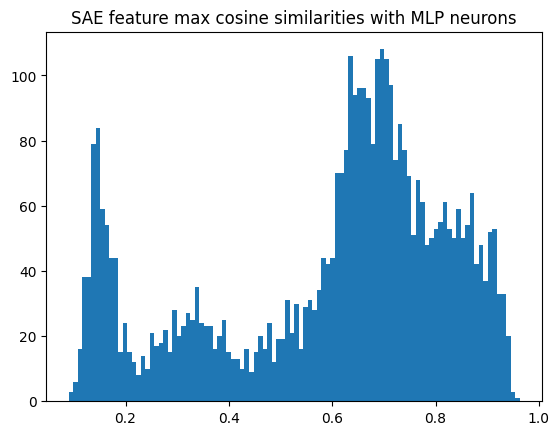

In [17]:
def get_cosine_similarities_for_mlp_neuron(model, feat_idx: int, layer: int, y_vectors_DF: t.Tensor) -> t.Tensor:
    d_model_vec = model.blocks[layer].mlp.W_out[feat_idx, :]

    y_vectors_FD = einops.rearrange(y_vectors_DF, 'd f -> f d')

    cosine_similarities = F.cosine_similarity(d_model_vec, y_vectors_FD)

    return cosine_similarities

def get_max_cos_sim_for_all_mlp_neurons(model, layer: int, y_vectors_DF: t.Tensor) -> t.Tensor:
    max_cos_sims = []

    for neuron_idx in range(model.blocks[layer].mlp.W_out.shape[0]):
        max_cos_sims.append(get_cosine_similarities_for_mlp_neuron(model, neuron_idx, layer, y_vectors_DF).max())
    return t.stack(max_cos_sims)

def get_cosine_similarities_for_ae_decoder_neuron(ae, feat_idx: int, layer: int, y_vectors_FD: t.Tensor) -> t.Tensor:
    d_model_vec = ae.decoder.weight[:, feat_idx]
    return F.cosine_similarity(d_model_vec, y_vectors_FD)

def get_max_cos_sim_for_all_ae_decoder_neurons(ae, layer: int, y_vectors_FD: t.Tensor) -> t.Tensor:
    max_cos_sims = []

    for neuron_idx in range(ae.decoder.weight.shape[1]):
        max_cos_sims.append(get_cosine_similarities_for_ae_decoder_neuron(ae, neuron_idx, layer, y_vectors_FD).max())
    return t.stack(max_cos_sims)

layer = 5

# cos sims for an individual neuron
mlp_neuron_idx = 1024
cos_sims_1024 = get_cosine_similarities_for_mlp_neuron(model, mlp_neuron_idx, layer, ae.decoder.weight)
print(f'Cos sim of mlp neuron {mlp_neuron_idx} with SAE feature 2192: {cos_sims_1024[2192]}')
print(f'Cos sim of mlp neuron {mlp_neuron_idx} with SAE feature 3098: {cos_sims_1024[3098]}')
print(f'Maximum cosine similarity of mlp neuron {mlp_neuron_idx}: {cos_sims_1024.max()}')

# max cos sims for all mlp neurons
max_cos_sims = get_max_cos_sim_for_all_ae_decoder_neurons(ae, layer, ae.encoder.weight)
average_max_cos_sim = max_cos_sims.mean()
print(average_max_cos_sim)

print(len(max_cos_sims))
print(t.sum(t.tensor(max_cos_sims) > 0.5).item())

plt.title(f'SAE feature max cosine similarities with MLP neurons')
plt.hist(max_cos_sims.cpu().numpy(), bins=100)

In [25]:
# This cell caches mlp activations and SAE feature activations for all games in the dataset

mlp_acts_bLF = {}
for layer in range(model.cfg.n_layers):
    mlp_acts_bLF[layer] = t.zeros((total_games_size, context_length, d_model * 4), dtype=t.float32, device=device)

tokens_bL = t.zeros((total_games_size, context_length), dtype=t.int16, device=device)
feature_activations_bLF = t.zeros((total_games_size, context_length, ae_hidden_dim), dtype=t.float32, device=device)

for i in range(0, total_games_size, batch_size):
    game_batch_BL = [next(data) for _ in range(batch_size)]
    game_batch_BL = t.tensor(game_batch_BL, device=device)
    with t.no_grad(), model.trace(game_batch_BL, scan=False, validate=False):
        x_BLD = submodule.output
        feature_acts_BLF = ae.encode(x_BLD).save()
        for layer in range(model.cfg.n_layers):
            mlp_acts_bLF[layer][i:i+batch_size] = mlp_post_submodules[layer].output.save()
    tokens_bL[i:i+batch_size] = game_batch_BL
    feature_activations_bLF[i:i+batch_size] = feature_acts_BLF

feature_activations_Fb = einops.rearrange(feature_activations_bLF, "B S F -> F (B S)")

for layer in mlp_acts_bLF:
    mlp_acts_bLF[layer] = einops.rearrange(mlp_acts_bLF[layer], "B S F -> F (B S)")
mlp_acts_Fb = {layer: mlp_acts_bLF[layer] for layer in mlp_acts_bLF}

In [33]:
# Pearson correlation calculation function
def pearson_corr(x, y):
    mean_x = x.mean(dim=-1, keepdim=True)
    mean_y = y.mean(dim=-1, keepdim=True)
    xm = x - mean_x
    ym = y - mean_y
    r_num = t.sum(xm * ym, dim=-1)
    r_den = t.sqrt(t.sum(xm * xm, dim=-1) * t.sum(ym * ym, dim=-1))
    
    with t.no_grad():
        zero_variance = (r_den == 0)
    r = t.where(zero_variance, t.zeros_like(r_num), r_num / r_den)

    return r


def get_correlation_for_activation(
    x_activations_Fb: t.Tensor, x_activation_index: int, y_activations_Fb: t.Tensor
) -> t.Tensor:
    x_activation_b = x_activations_Fb[x_activation_index]
    correlations = t.zeros(y_activations_Fb.shape[0])

    for i in range(y_activations_Fb.shape[0]):
        y_activation_b = y_activations_Fb[i]
        corr = pearson_corr(x_activation_b, y_activation_b)
        correlations[i] = corr

    return correlations

mlp_neuron_idx = 1024

feat_idx = 21

# sae_correlations = get_correlation_for_activation(feature_activations_Fb, feat_idx, mlp_acts_Fb[5])
mlp_correlations = get_correlation_for_activation(mlp_acts_Fb[5], mlp_neuron_idx, feature_activations_Fb)
sae_correlations = get_correlation_for_activation(feature_activations_Fb, feat_idx, feature_activations_Fb)

# Calculate Pearson correlation
# pearson_correlations = {}

# for layer in mlp_acts:
#     mlp_acts_layer = mlp_acts[layer]
#     correlations = t.zeros(mlp_acts_layer.shape[0])
#     for i in range(mlp_acts_layer.shape[0]):
#         mlp_feature = mlp_acts_layer[i]
#         corr = pearson_corr(feature_acts_BLF, mlp_feature)
#         correlations[i] = corr
#     pearson_correlations[layer] = correlations

torch.Size([2048, 4720])


100%|██████████| 4096/4096 [10:15<00:00,  6.65it/s]


[0.0, 0.29553383588790894, 0.9614431262016296, 0.0, 0.7641084790229797, 0.22990764677524567, 0.5451481938362122, 0.2251863330602646, 0.3226636052131653, 0.2335655689239502, 0.6689877510070801, 0.22140567004680634, 0.2279118150472641, 0.1335558295249939, 0.1596977561712265, 0.1572808474302292, 0.0, 0.14402320981025696, 0.0, 0.2619313895702362, 0.8065146207809448, 0.7909350395202637, 0.37070727348327637, 0.558750331401825, 0.23128795623779297, 0.11707092821598053, 0.7624120712280273, 0.3228757381439209, 0.4525402784347534, 0.23128259181976318, 0.18561403453350067, 0.19593879580497742, 0.3029438257217407, 0.262214332818985, 0.0, 0.18010303378105164, 0.2313448041677475, 0.0, 0.6667702794075012, 0.3368001878261566, 0.0, 0.6181948184967041, 0.0, 0.3752117156982422, 0.2059251368045807, 0.5556308627128601, 0.9291662573814392, 0.21961326897144318, 0.41263139247894287, 0.0, 0.3912429213523865, 0.0, 0.0, 0.27608755230903625, 0.09083446115255356, 0.796039342880249, 0.17843471467494965, 0.502640008

(array([ 9., 22., 32., 48., 65., 64., 75., 83., 93., 79., 92., 85., 88.,
        82., 73., 77., 69., 75., 63., 76., 72., 60., 62., 67., 61., 60.,
        44., 53., 36., 37., 47., 55., 44., 42., 33., 31., 20., 29., 26.,
        36., 28., 30., 24., 23., 30., 25., 22., 24., 23., 20., 26., 24.,
        18., 28., 20., 21., 19., 22., 23., 21., 25., 18., 22., 20., 13.,
        14., 21., 10., 23., 24., 20., 18., 18., 20., 12., 14., 16., 23.,
        21., 17., 18., 18., 12., 26., 25., 18., 21., 25., 21., 22., 23.,
        26., 34., 26., 25., 24., 17., 10.,  7., 12.]),
 array([0.08899003, 0.09805293, 0.10711583, 0.11617873, 0.12524162,
        0.13430452, 0.14336742, 0.15243032, 0.16149321, 0.17055611,
        0.17961901, 0.18868191, 0.1977448 , 0.2068077 , 0.2158706 ,
        0.2249335 , 0.23399639, 0.24305929, 0.25212219, 0.26118509,
        0.27024798, 0.27931088, 0.28837378, 0.29743668, 0.30649957,
        0.31556247, 0.32462537, 0.33368827, 0.34275116, 0.35181406,
        0.36087696, 0.3699

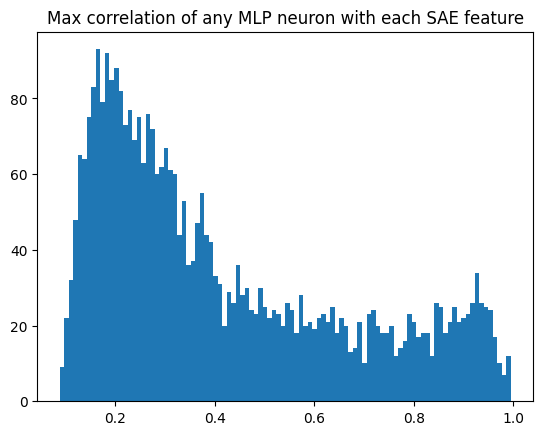

In [51]:
print(max_cors_sae)
# print average correlation

# remove all 0s
max_cors_sae_filtered = [x for x in max_cors_sae if x != 0]

print(t.mean(t.tensor(max_cors_sae_filtered)).item())

plt.title('Max correlation of any MLP neuron with each SAE feature')
plt.hist(max_cors_sae_filtered, bins=100)

In [52]:
# Number of matches with correlation > 0.5
print(len(max_cors_sae_filtered))
print(t.sum(t.tensor(max_cors_sae_filtered) > 0.5).item())

3515
1102


torch.Size([4096])
Index: 21, Value: 1.0
Index: 1743, Value: 0.45780685544013977
Index: 1491, Value: 0.2751590311527252
Index: 714, Value: 0.2666998505592346
Index: 2828, Value: 0.24140094220638275
Index: 2578, Value: 0.2320687621831894
Index: 2505, Value: 0.21343263983726501
Index: 104, Value: 0.1845957338809967
Index: 3164, Value: 0.17789562046527863
Index: 1075, Value: 0.17748446762561798
Index: 1394, Value: 0.16227270662784576
Index: 1113, Value: 0.1571427285671234
Index: 4072, Value: 0.15650488436222076
Index: 3354, Value: 0.14818619191646576
Index: 1146, Value: 0.14349788427352905
Index: 2589, Value: 0.14228761196136475
Index: 660, Value: 0.14132481813430786
Index: 3331, Value: 0.1403799206018448
Index: 1088, Value: 0.13689331710338593
Index: 3307, Value: 0.13666242361068726



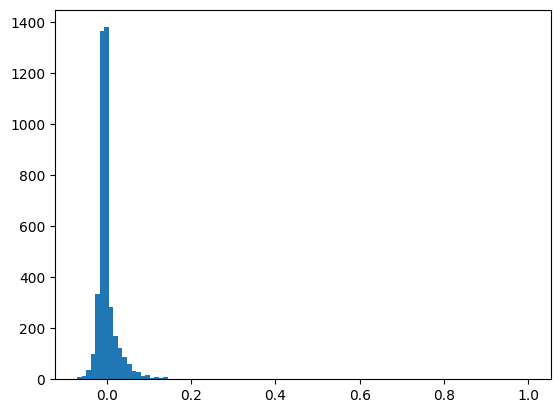

Index: 2535, Value: 0.7708338499069214
Index: 3098, Value: 0.4902779459953308
Index: 1916, Value: 0.2029569149017334
Index: 3165, Value: 0.18078529834747314
Index: 120, Value: 0.16435596346855164
Index: 1074, Value: 0.1587183028459549
Index: 3706, Value: 0.1582055538892746
Index: 1492, Value: 0.15480132400989532
Index: 1276, Value: 0.14913733303546906
Index: 4084, Value: 0.1464964747428894
Index: 2285, Value: 0.1276189386844635
Index: 487, Value: 0.1273309886455536
Index: 1279, Value: 0.11990320682525635
Index: 2570, Value: 0.11434376239776611
Index: 1471, Value: 0.1094914898276329
Index: 3896, Value: 0.10707065463066101
Index: 3069, Value: 0.10681899636983871
Index: 2088, Value: 0.10471779853105545
Index: 4087, Value: 0.10386072844266891
Index: 2204, Value: 0.10109879821538925



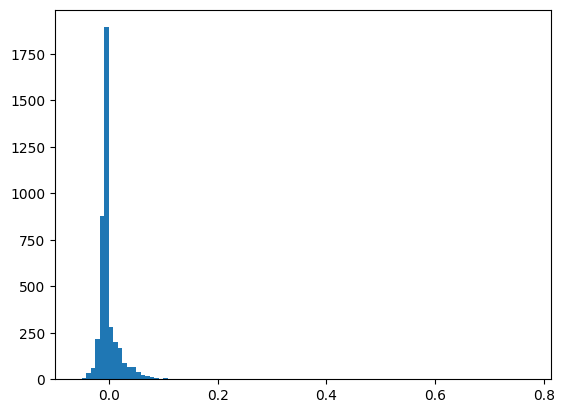

In [35]:
print(mlp_correlations.shape)


def analyze_correlations(correlations: t.Tensor):
    
    k = 20
    values, indices = t.topk(correlations, k)

    # Printing the top n values and their corresponding indices
    for index, value in zip(indices, values):
        print(f"Index: {index}, Value: {value.item()}")
    print()

    plt.hist(correlations.cpu().numpy(), bins=100)
    plt.show()


analyze_correlations(sae_correlations)
analyze_correlations(mlp_correlations)

In [ ]:
print(mlp_acts_Fb[5].shape)

max_cors_sae = []

# for i in tqdm(range(mlp_acts_Fb[5].shape[0])):
#     mlp_correlations = get_correlation_for_activation(mlp_acts_Fb[5], i, feature_activations_Fb)
#     max_correlation = t.max(mlp_correlations)
#     max_cors.append(max_correlation.item())

for i in tqdm(range(feature_activations_Fb.shape[0])):
    sae_correlations = get_correlation_for_activation(feature_activations_Fb, i, mlp_acts_Fb[5])
    max_correlation = t.max(sae_correlations)
    max_cors_sae.append(max_correlation.item())


In [28]:
# # Prepare data
# layers = list(pearson_correlations.keys())
# data = [pearson_correlations[l].abs() for l in layers]

# # Create stacked histogram
# plt.hist(data, bins=100, histtype='bar', stacked=True, label=layers)

# # Add legend and log scale for y-axis
# plt.legend(title='Layer')
# plt.yscale('log')

# # Display plot
# plt.xlabel('Absolute Pearson Correlation')
# plt.ylabel('Frequency')
# plt.title('Stacked Histogram of Pearson Correlations by Layer')
# plt.show()

In [29]:
# # save indices and layer for pearson_correlations above a certain threshold
# corr_threshold = 0.5
# indices = {}
# for layer in pearson_correlations:
#     indices[layer] = t.where(pearson_correlations[layer].abs() > corr_threshold)[0]

# indices